In [1]:
import os
import math
import numpy as npy
import scipy.signal as sp
import RefractiveIndex as ri
import matplotlib.pyplot as plt
import opticalCrossSection as ocs
from scipy.interpolate import interp1d
from scipy.interpolate import griddata

### Step 1: Parameter setting (manual)

In [2]:
# Definição dos parâmetros de análise e importação dos parâmetros materiais

## Se a NP for uma nanoesfera, shell_material equivale ao material da esfera
shell_material = 'Au'                                    
core_material = 'Silica'
medium_material = 'Water'

## Se True, é nanocasca. Se False, é nanoesfera
isShell = True

## Incluir correção de drude?
drude = False

## Raio da da nanoesfera ou núcleo (nm)
a_min = 10+30
a_max = 100+30
a_res = 1

## Espessura da casca (nm)
t_min = 10
t_max = 50
t_res = 1

## Extensão da análise
lambda_min = 400                                         
lambda_max = 1400
lambda_ref = 1240

### Step 2: Variable calculation (auto)

In [3]:
r = npy.linspace(a_min,a_max,int((a_max-a_min)/a_res+1))
th = npy.linspace(t_min,t_max,int((t_max-t_min)/t_res+1))
lspr_d = npy.empty((len(r), len(th)))
c_abs_d = npy.empty((len(r), len(th)))
c_sca_s = npy.empty((len(r), len(th)))
c_bck_s = npy.empty((len(r), len(th)))
eta_abs_d = npy.empty((len(r), len(th)))
eta_sca_s = npy.empty((len(r), len(th)))
joule_d = npy.empty((len(r), len(th)))
s2f_d = npy.empty((len(r), len(th)))
FB = npy.empty((len(r), len(th)))
for xx in range(0,len(r)-1,1):
    for yy in range(0,len(th)-1,1):
        a = r[xx]
        t = th[yy]
        if isShell:
            b = a + t
        else:
            b = a
        wlt, N, N1t, N2t, mu1, mu2 = ri.setupRI(shell_material,core_material,medium_material,
                                                a,b,lambda_min,lambda_max,isShell,drude)
        wl = []
        N1 = []
        N2 = []
        for ii in range(0,len(wlt)-1,1):
            if (((1e9)*wlt[ii])>=lambda_min) and (((1e9)*wlt[ii])<=lambda_max):
                wl = npy.append(wl,wlt[ii])
                N1 = npy.append(N1,N1t[ii])
                N2 = npy.append(N2,N2t[ii])
        if isShell:
            Csca, Cext, Cabs, Cbck = ocs.shellCS(wl*(1e9),N1,N2,N,mu1,mu2,a,b)
        else:
            Csca, Cext, Cabs, Cbck = ocs.sphereCS(wl*(1e9),N2,N,mu2,a)
        #teste1, teste2= sp.find_peaks(Cext)
        #dindex = teste1[len(teste1)-1]
        dindex = 69
        sindex = 92
        lspr_d[xx,yy] = (1e9)*float(wl[dindex])
        c_abs_d[xx,yy] = float(Cabs[dindex])
        c_sca_s[xx,yy] = float(Csca[sindex])
        eta_abs_d[xx,yy] = float(Cabs[dindex]/Cext[dindex])
        eta_sca_s[xx,yy] = float(Csca[sindex]/Cext[sindex])
        vol = 4*math.pi*((b*(1e-9))**3 - (a*(1e-9))**3)/3
        Req = (3*vol/(4*math.pi))**(1/3)
        joule_d[xx,yy] = lambda_ref*(1e-9)*((1e-18)*float(Cabs[dindex]))/(2*math.pi*vol)
        s2f_d[xx,yy] = ((1e-18)*float(Cabs[dindex]))/Req
        c_bck_s[xx,yy] = float(Cbck[sindex])
        FB[xx,yy] = float(Csca[sindex])/float(Cbck[sindex])

### Step 3: Data extraction in wavelenght of interest (auto)

radius_800 = []
thick_800 = []
cabs_800 = []
etaabs_800 = []
joule_800 = []
s2f_800 = []
radius_930 = []
thick_930 = []
cabs_930 = []
etaabs_930 = []
joule_930 = []
s2f_930 = []
for m in range(0,len(r)-1):
    for n in range(0,len(th)-1):
        if (lspr_d[m,n]>800-1 and lspr_d[m,n]<800+1):
            radius_800 = npy.append(radius_800,r[m])
            thick_800 = npy.append(thick_800,th[n])
            cabs_800 = npy.append(cabs_800,c_abs_d[m,n])
            etaabs_800 = npy.append(etaabs_800,eta_abs_d[m,n])
            joule_800 = npy.append(joule_800,joule_d[m,n])
            s2f_800 = npy.append(s2f_800,s2f_d[m,n])
        if (lspr_d[m,n]>930-5 and lspr_d[m,n]<930+5):
            radius_930 = npy.append(radius_930,r[m])
            thick_930 = npy.append(thick_930,th[n])
            cabs_930 = npy.append(cabs_930,c_abs_d[m,n])
            etaabs_930 = npy.append(etaabs_930,eta_abs_d[m,n])
            joule_930 = npy.append(joule_930,joule_d[m,n])
            s2f_930 = npy.append(s2f_930,s2f_d[m,n])
list1_800 = thick_800
list2_800 = radius_800
list1_800, list2_800 = zip(*sorted(zip(thick_800, radius_800)))
list1_800 = npy.array(list1_800)
list2_800 = npy.array(list2_800)
for h in range(1,len(list1)-1,1):
    if list1_800[h]==list1_800[h-1]:
        list1_800 = npy.delete(list1_800,h)
        list2_800 = npy.delete(list2_800,h)
fit_800 = npy.polyfit(list1_800,list2_800,4)
p_800 = npy.poly1d(fit_800)
list1_930 = thick_930
list2_930 = radius_930
list1_930, list2_930 = zip(*sorted(zip(thick_930, radius_930)))
list1_930 = npy.array(list1_930)
list2_930 = npy.array(list2_930)
for h in range(1,len(list1)-1,1):
    if list1_930[h]==list1_930[h-1]:
        list1_930 = npy.delete(list1_930,h)
        list2_930 = npy.delete(list2_930,h)
fit_930 = npy.polyfit(list1_930,list2_930,4)
p_930 = npy.poly1d(fit_930)
z = npy.linspace(t_min,t_max,100)

### Step 4: Data plotting (colormaps)

In [4]:
name = 'Gold-Silica_800nm'

fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)
#ax1.set_yticklabels([])
#ax1.set_xticklabels([])
pc1 = ax1.pcolormesh(th,2*r,lspr_d,cmap='inferno')
ax1.set_title("$\\lambda_{LSPR}$ (nm) - Dipole mode", va='bottom')
fig1.colorbar(pc1)
lines1 = plt.plot(z,2*p_800(z),'w--',z,2*p_930(z),'w-.',linewidth=2)
plt.legend(lines1[:2], ['800 nm','930 nm'],framealpha=0.5);
plt.savefig(name+'lspr.png',dpi=600,format='png')

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

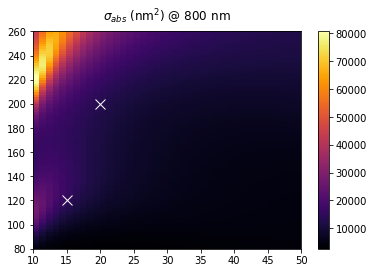

In [42]:
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)
#ax2.set_yticklabels([])
#ax2.set_xticklabels([])
pc2 = ax2.pcolormesh(th,2*r,c_abs_d,cmap='inferno')
ax2.set_title("$\\sigma_{abs}$ (nm$^2$) @ 800 nm", va='bottom')
fig2.colorbar(pc2)
plt.plot([15,20],[120,200],'wx',markersize=10)
plt.text(17,116.5,str(int(c_abs_d[(15-10)-1,(120-80)/2-1]))+' nm$^2$', fontdict=None,color='w',fontsize='large')
plt.text(20,200,str(int(c_abs_d[(20-10)-1,(200-80)/2-1]))+' nm$^2$', fontdict=None,color='w',fontsize='large')
#lines2 = plt.plot(z,2*p_800(z),'w--',z,2*p_930(z),'w-.',linewidth=2)
#plt.legend(lines2[:2], ['800 nm','930 nm'],framealpha=0.5,loc=4);

In [6]:
plt.savefig(name+'_cabs.png',dpi=600,format='png')

<Figure size 432x288 with 0 Axes>

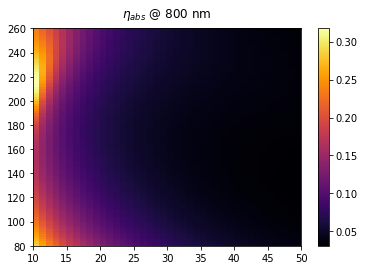

In [7]:
fig3 = plt.figure(3)
ax3 = fig3.add_subplot(111)
#ax3.set_yticklabels([])
#ax3.set_xticklabels([])
pc3 = ax3.pcolormesh(th,2*r,eta_abs_d,cmap='inferno')
ax3.set_title("$\\eta_{abs}$ @ 800 nm", va='bottom')
fig3.colorbar(pc3)
#lines3 = plt.plot(z,2*p_800(z),'w--',z,2*p_930(z),'w-.',linewidth=2)
#plt.legend(lines3[:2], ['800 nm','930 nm'],framealpha=0.5,loc=4);
#plt.savefig(name+'_etaabs.png',dpi=600,format='png')

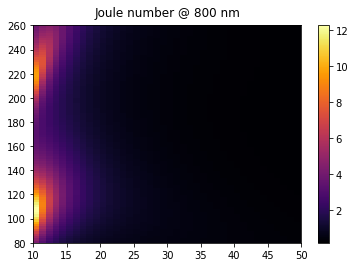

In [8]:
fig4 = plt.figure(4)
ax4 = fig4.add_subplot(111)
#ax4.set_yticklabels([])
#ax4.set_xticklabels([])
pc4 = ax4.pcolormesh(th,2*r,joule_d,cmap='inferno')
ax4.set_title("Joule number @ 800 nm", va='bottom')
fig4.colorbar(pc4)
#lines4 = plt.plot(z,2*p_800(z),'w--',z,2*p_930(z),'w-.',linewidth=2)
#plt.legend(lines4[:2], ['800 nm','930 nm'],framealpha=0.5,loc=4);
#plt.savefig(name+'_joule.png',dpi=600,format='png')

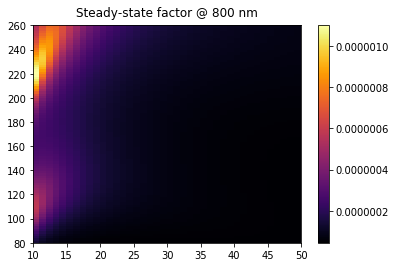

In [9]:
fig5 = plt.figure(5)
ax5 = fig5.add_subplot(111)
#ax5.set_yticklabels([])
#ax5.set_xticklabels([])
pc5 = ax5.pcolormesh(th,2*r,s2f_d,cmap='inferno')
ax5.set_title("Steady-state factor @ 800 nm", va='bottom')
fig5.colorbar(pc5)
#lines5 = plt.plot(z,2*p_800(z),'w--',z,2*p_930(z),'w-.',linewidth=2)
#plt.legend(lines5[:2], ['800 nm','930 nm'],framealpha=0.5,loc=4);
#plt.savefig(name+'_s2f.png',dpi=600,format='png')

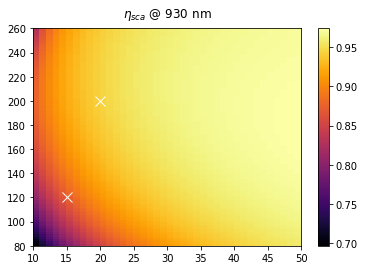

In [47]:
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)
#ax2.set_yticklabels([])
#ax2.set_xticklabels([])
pc2 = ax2.pcolormesh(th,2*r,eta_sca_s,cmap='inferno')
ax2.set_title("$\\eta_{sca}$ @ 930 nm", va='bottom')
fig2.colorbar(pc2)
plt.plot([15,20],[120,200],'wx',markersize=10)
#plt.text(17,116.5,str(int(c_abs_d[(15-10)-1,(120-80)/2-1]))+' nm$^2$', fontdict=None,color='w',fontsize='large')
#plt.text(20,200,str(int(c_abs_d[(20-10)-1,(200-80)/2-1]))+' nm$^2$', fontdict=None,color='w',fontsize='large')
#lines2 = plt.plot(z,2*p_800(z),'w--',z,2*p_930(z),'w-.',linewidth=2)
#plt.legend(lines2[:2], ['800 nm','930 nm'],framealpha=0.5,loc=4);

### Step 5: Data plotting (regular plots)

### Step 6: Export data

In [10]:
file = open(name+'_Shell_x.txt',"w")
npy.savetxt(name+'_Shell_x.txt', th, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ', encoding=None)
file.close()

In [11]:
file = open(name+'_Shell_y.txt',"w")
npy.savetxt(name+'_Shell_y.txt', r, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ', encoding=None)
file.close()

file = open(name+'_Shell_lspr.txt',"w")
npy.savetxt(name+'_Shell_lspr.txt', lspr_d, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ', encoding=None)
file.close()

In [12]:
file = open(name+'_Shell_cabs.txt',"w")
npy.savetxt(name+'_Shell_cabs.txt', c_abs_d, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ', encoding=None)
file.close()

In [13]:
file = open(name+'_Shell_eta.txt',"w")
npy.savetxt(name+'_Shell_eta.txt', eta_abs_d, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ', encoding=None)
file.close()

In [14]:
file = open(name+'_Shell_joule.txt',"w")
npy.savetxt(name+'_Shell_joule.txt', joule_d, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ', encoding=None)
file.close()

In [15]:
file = open(name+'_Shell_s2f.txt',"w")
npy.savetxt(name+'_Shell_s2f.txt', s2f_d, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ', encoding=None)
file.close()